### Helmholz

In [ ]:
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt 
from tmm.tmm import TMM
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

class TMM(TMM):
    def helmholtz_layer(self, t=100, d=10, v_radius=100, method="eq_fluid", layer=None):
        """
        Adds layer representing a Helmholtz ressonator to the existing device. 

        Parameters
        ----------
        t : float or int, optional
            Width of the ressonator bottleneck [mm]
        d : int or float
            Bottleneck diameter [mm]
        v_radius: int or float
            Volume radius of the ressonator cavity [mm]
        method : string, optional
            Chooses between the available methods to calculate resistive losses.
        layer : None or int, optional
            Optional value to choose the layer level. If None is passed the layer will be adding to the existing ones.
        """

        # Adjusting units
        t_meters = t / 1000
        d_meters = d / 1000
        v_radius_meters = v_radius / 1000
        v = (4/3)*np.pi*v_radius_meters**3
        bottleneck_area = np.pi*(d_meters**2) / 4 
        t_corr = t_meters + 0.85*(d_meters/2) # equivalent length
        rm = 0
        if method is None: # no losses, so expected absorption is zero
            kc = np.sqrt(self.k0 ** 2 - self.k0 ** 2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
        elif method == "eq_fluid": # Zwikker and Kosten viscothermic losses
            kc, zc = self.viscothermal_circular(d_meters, open_area=1)
            rho_c = (zc*self.w0) / (kc * (self.c0)**2)
        elif method == "ingard": # additional Rm term to account for losses
            kc = np.sqrt(self.k0 ** 2 - self.k0 ** 2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
            rm = 0.00166*np.sqrt(self.freq) * ((t_corr + 0.5*d_meters) / (self.rho0*self.c0*0.5*d_meters)) + ((self.rho0*self.c0*self.k0**2 * bottleneck_area) / (2*np.pi))
        else:
            raise AttributeError("method not available.")

        # Helmholtz ressonator impedance
        zr = rm + 1j * (self.c0*kc*rho_c*t_corr - ((rho_c*(self.c0)**2 * bottleneck_area) / (v*self.c0*kc)))
    
        zr = matlib.repmat(zr, len(self.incidence_angle), 1).T
        ones = np.ones_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))
        zeros = np.zeros_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))

        # create parallel ressonator matrix 
        Ta = np.array([[ones, zeros],
                        [bottleneck_area / zr, ones]])

        if layer is None:
            layer = len(self.matrix)

        self.matrix[layer] = {"type": "helmholtz_layer",
                              "thickness [mm]": t,
                              "tube_diameter [mm]": d,
                              "volume_radius [mm]": v_radius,
                              "matrix": Ta,
                              }

Device properties:
	(1 - Front face)
	(2 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  helmholtz_layer
	thickness [mm]: 5.00 | thickness [inches]: 0.20
	tube_diameter [mm]: 15.00 | tube_diameter [inches]: 0.59
	volume_radius [mm]: 40.70 | volume_radius [inches]: 1.60
Layer 2:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 5.00 | Total treatment depth [inches]: 0.20
Image saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.png


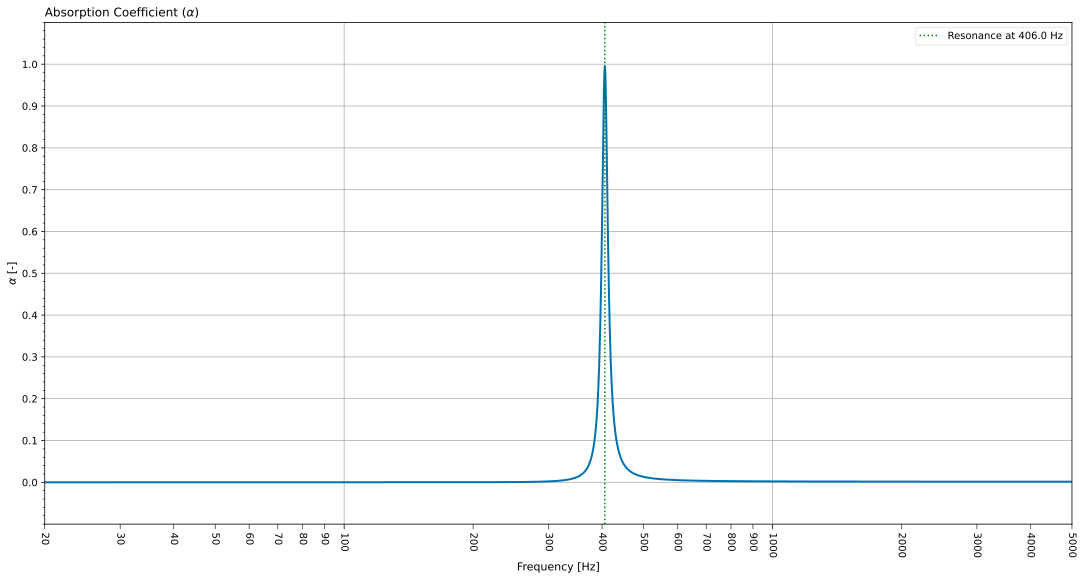

Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.h5


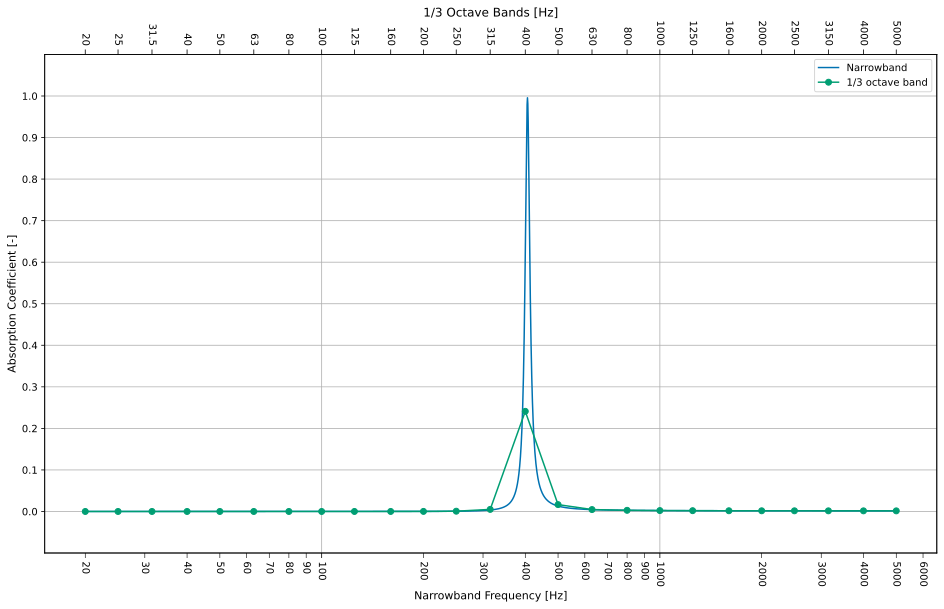

In [ ]:
treatment = TMM(fmin=20, fmax=5000, df=1, incidence="normal", filename="helmholtz")
# specify device front termination area
treatment.s0 = 0.1

treatment.helmholtz_layer(t=5, d=15, v_radius=40.7, method="ingard")

# Compute, plot and export data
treatment.compute(rigid_backing=True, show_layers=True)
treatment.plot(plots=["alpha"], save_fig=True)
treatment.save2sheet(n_oct=3)
treatment.save()
bands, filtered_alpha = treatment.filter_alpha(view=True, n_oct=3)


### Placa perfurada

Device properties:
	(1 - Front face)
	(4 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  perforated_panel_layer
	thickness [mm]: 19.00 | thickness [inches]: 0.75
	hole_diameter [mm]: 8.00 | hole_diameter [inches]: 0.31
	hole_spacing [mm]: 24.00 | hole_spacing [inches]: 0.94
	open_area [%]: 8.73
	end_correction:  jb
	rho [kg/m3]: None
	method:  eq_fluid
Layer 2:
	type:  porous_layer
	flow_resistivity [k*Pa*s/m²]: 27.00
	thickness [mm]: 50.00 | thickness [inches]: 1.97
	model:  mac
Layer 3:
	type:  air_layer
	thickness [mm]: 50.00 | thickness [inches]: 1.97
Layer 4:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 119.00 | Total treatment depth [inches]: 4.69
Image saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada.png


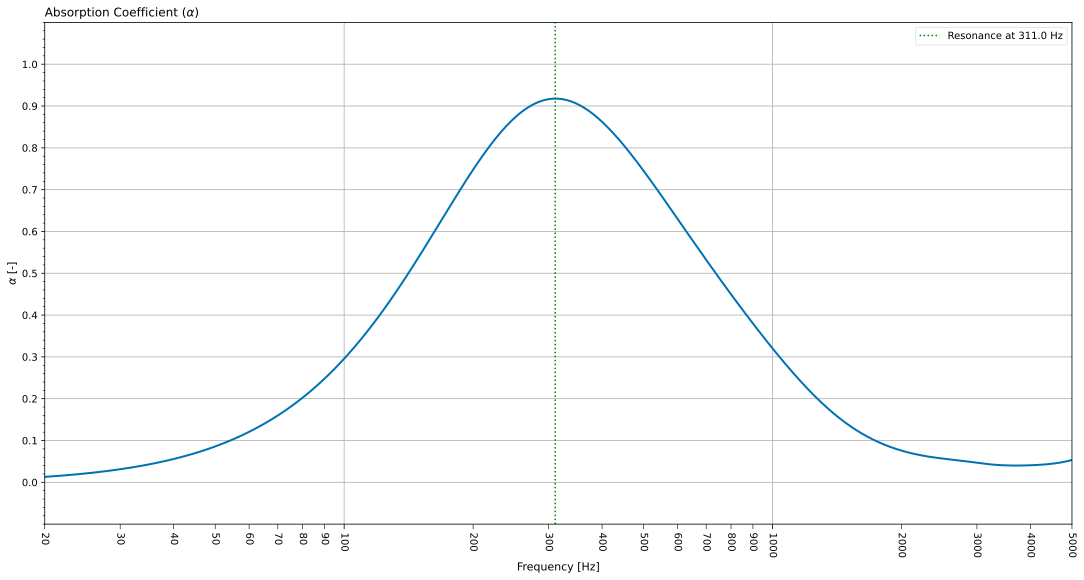

Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada.h5


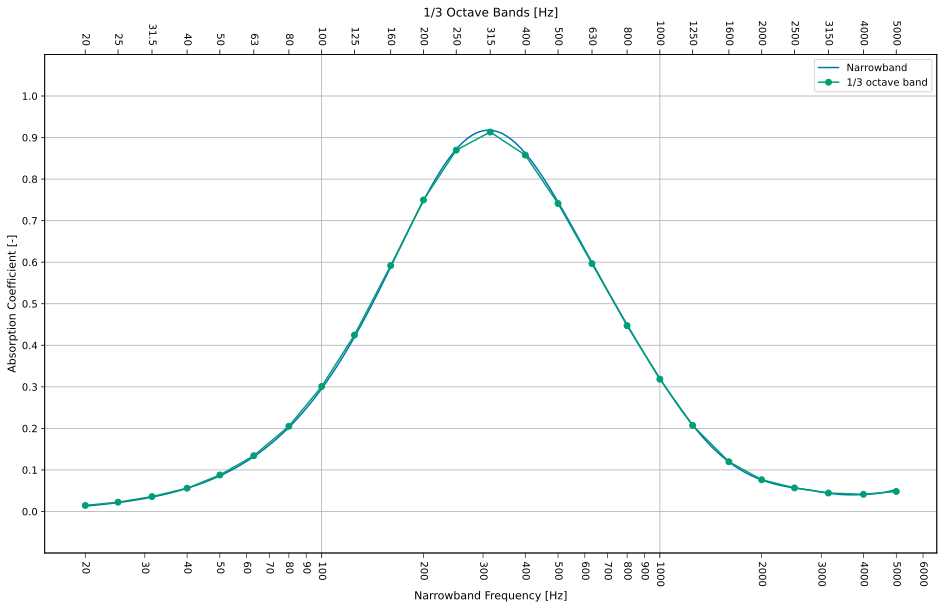

In [11]:
# Define the frequency range, resolution and sound incidence
treatment = TMM(fmin=20, fmax=5000, df=1, incidence="normal", filename="placa_perfurada")

# Define the layers - from top to bottom
treatment.perforated_panel_layer(t=19, d=8, s=24, method="eq_fluid") # Use Zwikker&Kosten method
treatment.porous_layer(model="mac", t=50, sigma=27) # Allard-Champoux model
treatment.air_layer(t=50)

# Compute, plot and export data
treatment.compute(rigid_backing=True, show_layers=True)
treatment.plot(plots=["alpha"], save_fig=True)
treatment.save2sheet(n_oct=3)
treatment.save()
bands, filtered_alpha = treatment.filter_alpha(view=True, n_oct=3)

### Amortecedor de vibrações

/tmp/ipykernel_42302/2883891689.py:23: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim((freq[0], freq[-1]))
/tmp/ipykernel_42302/2883891689.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


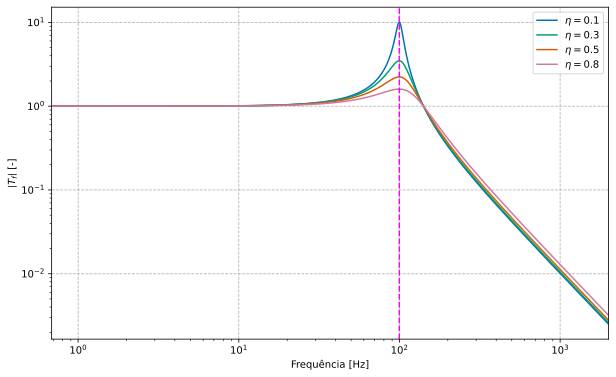

In [62]:
m = 0.5 # mass [kg]
E = 0.01e9 # young's modulus [Pa]
d = 0.05 # diameter [m]
A = (np.pi*d**2) / 4 # area [m^2]
L = 0.1 # width [m] 
k= (E*A) / L# stiffness [N/m]

etas = np.array([0.1, 0.3, 0.5, 0.8]) # loss factor

w_n=np.sqrt(k/m) # natural frequecy [rad/s]
freq = np.arange(0, 2000, 1)
w=2*np.pi*freq

fig, ax = plt.subplots(figsize=(10, 6))
for eta in etas:
    kc = k*(1 + 1j*eta)
    Tf= np.abs(kc / (kc - w**2 * m))
    ax.loglog(freq, Tf, label=rf"$\eta = {eta}$")

ax.grid(linestyle = '--', which='major')
ax.set_xlabel('Frequência [Hz]')
ax.set_ylabel(r'$\left|T_f\right|$ [-]')
ax.set_xlim((freq[0], freq[-1]))
ax.axvline(x=(w_n/(2*np.pi)), linestyle="--", color="magenta")
ax.legend()
fig.show()